In [1]:
import os
import pydicom
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
train_data_path = '../dataset/stage_1_train_images'
train_csv_path = "../dataset/stage_1_train.csv"
img_names = os.listdir(train_data_path)

In [3]:
def loadTrainingData():
    train_pred_data = pd.read_csv(train_csv_path, index_col=False)
    train_pred_data.index = train_pred_data['ID'].values
    return train_pred_data

In [4]:
train_pred_data = loadTrainingData()

In [5]:
len(img_names)

674258

In [6]:
train_pred_data[:6]

,ID,Label
ID_63eb1e259_epidural,ID_63eb1e259_epidural,0
ID_63eb1e259_intraparenchymal,ID_63eb1e259_intraparenchymal,0
ID_63eb1e259_intraventricular,ID_63eb1e259_intraventricular,0
ID_63eb1e259_subarachnoid,ID_63eb1e259_subarachnoid,0
ID_63eb1e259_subdural,ID_63eb1e259_subdural,0
ID_63eb1e259_any,ID_63eb1e259_any,0


# Split data into categories

In [7]:
categorized_images = {
    'epidural' : {0:[], 1:[]}, 
    'intraparenchymal' : {0:[], 1:[]}, 
    'intraventricular' : {0:[], 1:[]}, 
    'subarachnoid' : {0:[], 1:[]}, 
    'subdural' : {0:[], 1:[]},
    'any' : {0:[], 1:[]}
}

In [8]:
%%time
for img_id_cat,label in train_pred_data.values:
    img_id = img_id_cat[:12]
    cat = img_id_cat[13:]
    categorized_images[cat][label].append(img_id)

CPU times: user 3.96 s, sys: 295 ms, total: 4.25 s
Wall time: 4.25 s


In [9]:
len(categorized_images["any"][0]) + len(categorized_images["any"][1])

674262

# Analyze

<BarContainer object of 6 artists>

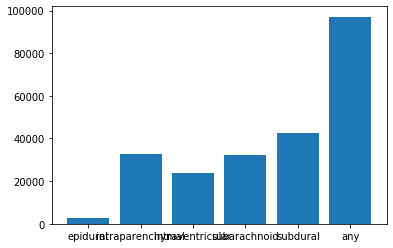

In [10]:
plt.bar(list(categorized_images.keys()), [len(categorized_images[cat][1]) for cat in categorized_images])

# Process

In [10]:
import numpy as np
def getImg(img_name):
    '''Scale pixel data to Hounsfield units with a linear transformation'''
    dc = pydicom.dcmread(os.path.join(train_data_path, img_name)+".dcm")
    intercept = dc[('0028','1052')].value
    slope = dc[('0028','1053')].value
    return dc.pixel_array * slope + intercept   

In [11]:
def cleanDC(img, clip_range = (13,75)):
    
    # Clamp pixel values to only HU range we want
    clipped = np.clip(img, clip_range[0], clip_range[1])
    
    # Normlaize pixels from 0-1
    norm = (clipped - min(clipped.flatten())) / (max(clipped.flatten())-min(clipped.flatten()))
    
    # Scale values from 0-255 for CNN's
    #rgb_scaled = 255 * norm

    return norm

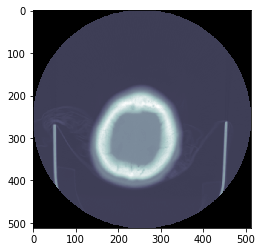

In [14]:
# Test raw
plt.imshow(getImg(hem[0]), cmap="bone")

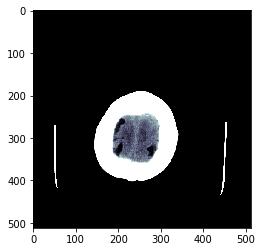

In [15]:
# Test Processed
plt.imshow(cleanDC(getImg(hem[0]), (13,75)), cmap="bone")

# Save

## Hem or No hem

In [16]:
hem = categorized_images["any"][1]
nohem = categorized_images["any"][0]

In [ ]:
plt.bar(['Hem', 'No Hem'], [len(hem), len(nohem)])

In [ ]:
os.mkdir("Processed")
os.mkdir("Processed/Binary")
os.mkdir("Processed/Binary/Hem")
os.mkdir("Processed/Binary/NoHem")

In [17]:
import pickle
def saveFile(img_array, img_name, dir_path):
    pickle.dump(img_array, open(dir_path+"/"+img_name+".pickle", 'wb'))
def cleanImg(img_name):
    img = getImg(img_name)
    return cleanDC(img)

In [23]:
from multiprocessing import Pool

def cleanNSave(img):
    
    if os.path.exists("Processed/Binary/NoHem/" + img + ".dcm"): 
        return None
    try:
        cleaned_img = cleanImg(img)
        saveFile(cleaned_img, img, "Processed/Binary/NoHem")
    except:
        return img

# p = Pool()
# undone = p.map(cleanNSave, hem)
# p.close()
# p.join()

In [24]:
%time cleanNSave(nohem[-20])

CPU times: user 73 ms, sys: 0 ns, total: 73 ms
Wall time: 327 ms


In [ ]:
while None in undone:
    undone.remove(None)

In [ ]:
len(undone)